**PROBLEM STATEMENT:**

1. In recent years, as material becomes more comprehensive, it becomes
increasingly difficult for people to find the information that is relevant to them.

2. In both a societal and corporate perspective, the ability to find the information you need, provided to you in a digestible and easy to understand format, becomes more vital as time passes.

3. However the amount of processing power needed for this, is exponentially increasing.


Downloading Libraries

In [20]:
!pip install langchain openai huggingface_hub python-dotenv chromadb langchain_openai langchain_chroma nltk evaluate
!pip install python-gemini-api
! pip install pinecone-client

! pip install -U langchain-community
! pip install langchain_pinecone
! pip install google-generativeai
! pip install langchain-google-genai

!pip install transformers
!pip install torch
!pip install torchvision
!pip install Pillow
! pip install rouge_score


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv, find_dotenv
from huggingface_hub import hf_hub_download
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from google.auth import default
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import io
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

import openai
import sys
from langchain_openai import OpenAIEmbeddings
from more_itertools import chunked
from langchain.chains import ConversationalRetrievalChain
from langchain_openai import ChatOpenAI
import nltk
from nltk.translate.bleu_score import sentence_bleu
from evaluate import load
import ast
import logging
import re
from langchain.schema import Document
from langchain_pinecone import PineconeVectorStore
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
import time
from google.api_core.exceptions import ResourceExhausted
from rouge_score import rouge_scorer

import warnings
langchain_logger = logging.getLogger('langchain_google_genai.chat_models')
langchain_logger.setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import nltk
nltk.download('punkt')

OPENAI_API_KEY = 'INSERT API KEY HERE'
openai.api_key  = OPENAI_API_KEY

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**DATA SOURCES:**

We have pulled the data from the ScienceQA dataset on Hugging Face.

Downloading Dataset

In [3]:
!git lfs install
!git clone https://huggingface.co/datasets/derek-thomas/ScienceQA

Git LFS initialized.
Cloning into 'ScienceQA'...
remote: Enumerating objects: 51, done.
remote: Total 51 (delta 0), reused 0 (delta 0), pack-reused 51 (from 1)
Unpacking objects: 100% (51/51), 115.26 KiB | 2.56 MiB/s, done.
Filtering content: 100% (3/3), 597.08 MiB | 40.97 MiB/s, done.


Splitting Dataset

In [4]:
splits = {'train': 'data/train-00000-of-00001-1028f23e353fbe3e.parquet', 'validation': 'data/validation-00000-of-00001-6c7328ff6c84284c.parquet', 'test': 'data/test-00000-of-00001-f0e719df791966ff.parquet'}
df = pd.read_parquet("ScienceQA/" + splits["train"])
df_test = pd.read_parquet("ScienceQA/" + splits["test"])
df_validate = pd.read_parquet("ScienceQA/" + splits["validation"])
selected_cols = df[['question','answer','solution', 'choices', 'hint', 'task', 'grade','subject', 'topic', 'category', 'skill', 'lecture']]
selected_cols.head()

,question,answer,solution,choices,hint,task,grade,subject,topic,category,skill,lecture
0,Which of these states is farthest north?,0,"To find the answer, look at the compass rose. ...","[West Virginia, Louisiana, Arizona, Oklahoma]",,closed choice,grade2,social science,geography,Geography,Read a map: cardinal directions,"Maps have four cardinal directions, or main di..."
1,Identify the question that Tom and Justin's ex...,1,,[Do ping pong balls stop rolling along the gro...,The passage below describes an experiment. Rea...,closed choice,grade8,natural science,science-and-engineering-practices,Designing experiments,Identify the experimental question,Experiments can be designed to answer specific...
2,Identify the question that Kathleen and Bryant...,0,,[Does Kathleen's snowboard slide down a hill i...,The passage below describes an experiment. Rea...,closed choice,grade7,natural science,science-and-engineering-practices,Designing experiments,Identify the experimental question,Experiments can be designed to answer specific...
3,Which tense does the sentence use?\nMona will ...,1,The sentence is in future tense. You can tell ...,"[present tense, future tense, past tense]",,closed choice,grade2,language science,verbs,Verb tense,"Is the sentence in the past, present, or futur...",Present tense verbs tell you about something t...
4,Complete the sentence.\nSewing an apron is a ().,1,Sewing an apron is a physical change. The fabr...,"[chemical change, physical change]",,closed choice,grade4,natural science,chemistry,Physical and chemical change,Identify physical and chemical changes,Chemical changes and physical changes are two ...


**EXPLORATORY ANALYSIS OF DATA:**

The snippet below is to process data since it's read as a whole paragraph above. We are separating the choices column since it consists of a list.


Creating Document for VectorDB

In [5]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

documents = []
for idx, row in selected_cols.iterrows():
    choices = row['choices']

    new_choice = []

    if isinstance(choices, str):
        try:
            new_choice = ast.literal_eval(choices)
            if not isinstance(new_choice, list):
                logger.warning(f"choice not a list row {idx}, empty list created!")
                new_choice = []
        except (ValueError, SyntaxError):
            logger.warning(f"no choice for row {idx}, get solution or text instead.")
            new_choice = []
    elif isinstance(choices, list):
        new_choice = choices
    elif isinstance(choices, np.ndarray):
        new_choice = choices.tolist()
    else:
        logger.warning(f"choices type {type(choices)} for row {idx}, get solution or text instead.")
        new_choice = []

    if not new_choice:
        raw_solution = row.get('solution', '')
        raw_text = row.get('text', '')


        extracted_choices = re.findall(r'\d+\.\s*(.*?)(?=\d+\.\s*|$)', raw_solution)
        if not extracted_choices:
            extracted_choices = re.findall(r'\d+\.\s*(.*?)(?=\d+\.\s*|$)', raw_text)

        if extracted_choices:
            new_choice = [choice.strip() for choice in extracted_choices]
            logger.info(f"{len(new_choice)} choices received, for row {idx} from 'solution' or 'text'.")
        else:
            logger.warning(f"no choice found for row {idx}, empty list created!")
            new_choice = []

    metadata = {
        "choices": new_choice,
        "hint": row.get('hint', "N/A"),
        "task": row.get('task', "N/A")
    }

    page_content = " ".join([
        str(value) for key, value in row.items()
        if key not in ['choices', 'hint', 'task', 'solution'] and pd.notnull(value)
    ])

    documents.append(Document(page_content=page_content, metadata=metadata))


for doc in documents[:5]:
    print("Choices:", doc.metadata['choices'])
    print("Page Content:", doc.page_content)
    print("-" * 50)


Choices: ['West Virginia', 'Louisiana', 'Arizona', 'Oklahoma']
Page Content: Which of these states is farthest north? 0 grade2 social science geography Geography Read a map: cardinal directions Maps have four cardinal directions, or main directions. Those directions are north, south, east, and west.
A compass rose is a set of arrows that point to the cardinal directions. A compass rose usually shows only the first letter of each cardinal direction.
The north arrow points to the North Pole. On most maps, north is at the top of the map.
--------------------------------------------------
Choices: ['Do ping pong balls stop rolling along the ground sooner after being launched from a 30° angle or a 45° angle?', 'Do ping pong balls travel farther when launched from a 30° angle compared to a 45° angle?']
Page Content: Identify the question that Tom and Justin's experiment can best answer. 1 grade8 natural science science-and-engineering-practices Designing experiments Identify the experimental

The data gets split into chunks to fit into the different model's context window.

Splitting the Document into Chunks

In [6]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
split_documents = text_splitter.split_documents(documents)

The image data gets captioned to be used by the LLM.

Image Captioning

In [7]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Retriving API Keys

In [8]:
from google.colab import userdata
os.environ['PINECONE_API_KEY'] = userdata.get('PINECONE_API_KEY')


##GEMINI

1.Embedding

In [21]:
index_name = "scienceqa-index-gemini"
embedding_model = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", google_api_key='INSERT API KEY HERE')

2.Pinecone

***Note:Uncomment and run this only if you want to embed the data for the first time.




In [ ]:
#docsearch = PineconeVectorStore.from_documents(split_documents, embedding_model, index_name=index_name)

3.Retriving from existing Pinecone

**Note: Run this cell if you already have existing data in Pinecone

In [10]:
from langchain.vectorstores import Pinecone
docsearch = Pinecone.from_existing_index(
    index_name='scienceqa-index-gemini',
    embedding=embedding_model
)

4.Verifying Metadata

In [11]:
index_stats = docsearch._index.describe_index_stats()
vector_count = index_stats['namespaces']['']['vector_count']
print(f"Total vectors stored in Pinecone index: {vector_count}")

sample_data = docsearch._index.fetch(ids=["28fbf62a-af63-4265-b168-60325a2ebb4f"])

for vector_id, vector_info in sample_data['vectors'].items():
    print(f"Vector ID: {vector_id}")
    print("Embedding (first 10 elements):", vector_info['values'][:10])
    print("Metadata:", vector_info['metadata'])
    print("\n")


Total vectors stored in Pinecone index: 12726
Vector ID: 28fbf62a-af63-4265-b168-60325a2ebb4f
Embedding (first 10 elements): [-0.0450857393, 0.0595692135, -0.0259057898, 0.0143382419, 0.0185793713, 0.00104992837, -0.024402367, -0.0203808788, 0.0124397231, 0.00975462422]
Metadata: {'choices': ['pollinated cones', 'male cones'], 'hint': 'This diagram shows the life cycle of a pine tree.', 'task': 'closed choice', 'text': "Which cones make pollen? 1 grade8 natural science biology Plant reproduction Angiosperm and conifer life cycles Gymnosperms are plants that have seeds but not flowers. Conifers are a type of a gymnosperm. Instead of flowers, conifers have cones. Conifers use their cones for sexual reproduction.\nMost conifer trees have both male and female cones. The male cones produce pollen. The female cones produce eggs and a sticky substance on the edge of the cone.\nMale cones release pollen into the wind. Pollination happens when pollen lands on and sticks to the female cones. Sel

##OPENAI

1.Embedding

In [12]:
! pip install sentence-transformers

In [13]:
from sentence_transformers import SentenceTransformer
embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-distilroberta-v1")

index = "scienceqa-index-openai"

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2.Pinecone

***Note: Uncomment and run this only if you want to embed the data for the first time.

In [ ]:
'''vector_store = PineconeVectorStore.from_existing_index(
    index_name=index,
    embedding=embed_model
)

batch_size = 256
def batch_process(documents, batch_size):
    for i in range(0, len(documents), batch_size):
        yield documents[i:i + batch_size]


for batch in batch_process(split_documents, batch_size):
    vector_store.add_documents(batch)'''

3.Retriving from existing Pinecone

**Note: Run this cell if you already have existing data in Pinecone

In [14]:
from langchain_pinecone import PineconeVectorStore
vector_store = PineconeVectorStore.from_existing_index(
    index_name=index,
    embedding=embed_model
)

4.Verifying Metadata

In [15]:
idx_stats = vector_store._index.describe_index_stats()

vector_count = idx_stats['namespaces']['']['vector_count']
print(f"Total vectors stored: {vector_count}")

smp_data = vector_store._index.fetch(ids=["11b2629d-8fe6-4ca6-b33d-1cb5578cac1b"])

for vector_id, vector_info in smp_data['vectors'].items():
    print(f"Vector ID: {vector_id}")
    print("Embedding (first 10 elements):", vector_info['values'][:10])
    print("Metadata:", vector_info['metadata'])
    print("\n")

Total vectors stored: 12726
Vector ID: 11b2629d-8fe6-4ca6-b33d-1cb5578cac1b
Embedding (first 10 elements): [0.00434512366, 0.0347029, 0.051164303, 0.00360231684, 0.00819951575, -0.0239859354, -0.00856999401, 0.10328836, 0.0113646779, 0.020338567]
Metadata: {'choices': ['50 millimeters', '50 kilometers', '50 centimeters', '50 meters'], 'hint': 'Select the best estimate.', 'task': 'closed choice', 'text': 'How long is a garden snail? 0 grade7 natural science units-and-measurement Units and measurement Choose metric units of distance, mass, and volume Measurements are written with both a number and a unit. The unit comes after the number. The unit shows what the number means.\nWhen you are using metric units, length can be written with units of millimeters, centimeters, meters, or kilometers. One meter contains 100 centimeters or 1,000 millimeters. So, 1 meter is larger than 1 centimeter, and 1 centimeter is larger than 1 millimeter.\nThe tip of the pencil shown here is only 1 millimeter 

Defining Gemini LLM

In [22]:
Gemini_llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-001",
    temperature=0.0,
    max_tokens=256,
    timeout=30,
    max_retries=2,
    api_key='INSERT API KEY HERE'
)

Defining OpenAI LLM

In [17]:
os.environ["OPENAI_API_KEY"] ='INSERT API KEY HERE'

OpenAI_llm = ChatOpenAI(model_name="gpt-4o-mini-2024-07-18")

Function for Processing the query and to define prompt for the LLM

In [18]:
def ask_question(query, llm, vectordb):
    retrieved_docs = vectordb.as_retriever().get_relevant_documents(query)

    if retrieved_docs:
        primary_doc = retrieved_docs[0]
        context = primary_doc.page_content
        options = primary_doc.metadata.get("choices", [])
        hint = primary_doc.metadata.get("hint", "N/A")
        task = primary_doc.metadata.get("task", "N/A")
        image = primary_doc.metadata.get("image", None)
    else:
        context = ""
        options = []
        hint = "N/A"
        task = "N/A"
        image = None


    image_part = ""
    if image:
        try:
            from transformers import BlipProcessor, BlipForConditionalGeneration
            import torch
            import io
            from PIL import Image

            if 'processor' not in globals():
                global processor
                processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
            if 'blip_model' not in globals():
                global blip_model
                blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

            if isinstance(image, dict) and 'bytes' in image:
                img = Image.open(io.BytesIO(image['bytes'])).convert('RGB')
            elif isinstance(image, str) and image.startswith('http'):
                import requests
                response = requests.get(image)
                img = Image.open(io.BytesIO(response.content)).convert('RGB')
            else:
                logger.warning(f"Unsupported image format: {type(image)}")
                img = None

            if img is not None:
                inputs = processor(img, return_tensors="pt")
                out = blip_model.generate(**inputs)
                caption = processor.decode(out[0], skip_special_tokens=True)
                image_part = f"Image Caption: {caption}"
        except Exception as e:
            logger.warning(f"Failed to process image: {e}")
            image_part = ""
    else:
        image_part = ""
    options_text = "\n".join([f"- {opt}" for opt in options]) if options else "No options available"

    template = f"""
Use the following context retrieved from similar training data to answer the question.
Base your answer solely on this context. You can use the context and hint to make calculations and inferences on your own.

Provide your answer in two parts:
1. Reasoning for the answer: Explain how you arrived at the answer based on the context and your understanding.
2. Answer from the choices: Select the correct answer from the options provided below.


**Available Options**:
{options_text}

**Information Provided:**
Context: {{context}}
Question: {query}
{image_part}
Hint: {hint}
Task: {task}

**Final Answer**: Select the correct choice from above and print it in a new line
"""

    QA_CHAIN_PROMPT = PromptTemplate(
        input_variables=["context", "question", "hint", "task"],
        template=template
    )

    qa_chain = RetrievalQA.from_chain_type(
        llm,
        retriever=vectordb.as_retriever(),
        return_source_documents=True,
        chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
    )

    result = qa_chain({
        "query": query,
        "context": context,
        "question": query,
        "hint": hint,
        "task": task
    })

    return result["result"]


Gemini Query

In [23]:
query = "Which animal's neck is also adapted for reaching high branches?"
answer = ask_question(query, Gemini_llm, docsearch)
print("Answer:", answer)

Answer: 1. **Reasoning:** The context mentions that a long neck helps an animal get food from tall trees. The hint states that giraffes eat leaves and twigs, implying they have long necks to reach high branches. 

2. **Answer from the choices:**  
giraffe 



OpenAI Query

In [24]:
query = "Which animal's neck is also adapted for reaching high branches?"
answer = ask_question(query, OpenAI_llm, vector_store)
print("Answer:", answer)

Answer: 1. Reasoning for the answer: The context provided talks about animal adaptations, specifically mentioning how the shape of an animal's neck can be adapted to help them reach food from tall trees. The hint explicitly states that giraffes eat leaves and twigs and have necks adapted for reaching high branches. This clearly indicates that the answer to the question regarding which animal's neck is adapted for reaching high branches would be the giraffe. The available options do not include giraffe, but the context leads to the conclusion that the animal with such adaptations is indeed the giraffe. Among the provided choices, the chital (a type of deer) and bison do not have adaptations for reaching high branches like a giraffe does.

2. Answer from the choices: chital


#BLEU and ROUGE Score

1.Tokenization


In [25]:
smoothie = SmoothingFunction().method1
def extract_final_answer(model_output):
    pattern = r'(?:2\.\s*Answer from the choices:|Final Answer\*\*:)(.*)'
    match = re.search(pattern, model_output, re.DOTALL)
    if match:
        final_answer = match.group(1).strip()
        final_answer = re.sub(r'[\*\-#]', '', final_answer).strip()
        return final_answer
    else:
        return model_output.strip()

def clean_reference_answer(reference_answer):
    reference_answer = reference_answer.strip()
    reference_answer = re.sub(r'[\*\-#]', '', reference_answer).strip()
    return reference_answer

def ask_question_with_retry(query, llm, vectordb, max_retries=3):
    delay = 1
    for attempt in range(max_retries):
        try:
            return ask_question(query, llm, vectordb)
        except ResourceExhausted as e:
            print(f"Attempt {attempt + 1}: ResourceExhausted error. Retrying in {delay} seconds...")
            time.sleep(delay)
            delay *= 2
    raise Exception("Exceeded maximum retries due to ResourceExhausted error.")

def compute_rouge_scores(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)
    return {
        'rouge_1': scores['rouge1'].fmeasure,
        'rouge_2': scores['rouge2'].fmeasure,
        'rouge_L': scores['rougeL'].fmeasure
    }

selected_cols_test = df_test[['question', 'answer', 'solution', 'choices', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture']]
test_samples = selected_cols_test.iloc[:500]

selected_cols_val = df_validate[['question', 'answer', 'solution', 'choices', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture']]
val_samples = selected_cols_val.iloc[:500]


2.Gemini Calculation for BLEU and ROUGE Score

2.1.Validation Dataset

In [26]:
reference_texts_gemini_val = []
generated_texts_gemini_val = []
individual_bleu_scores_gemini_val = []
individual_rouge_scores_gemini_val = {'rouge_1': [], 'rouge_2': [], 'rouge_L': []}

for index, row in test_samples.iterrows():
    query = row['question']
    reference_answer_gemini_val = clean_reference_answer(row['solution'])

    try:
        model_answer_gemini_val = ask_question_with_retry(query, Gemini_llm, docsearch)
    except Exception as e:
        #print(f"Failed to process sample {index + 1}: {e}")
        continue

    final_model_answer_gemini_val = extract_final_answer(model_answer_gemini_val)

    reference_texts_gemini_val.append([reference_answer_gemini_val])
    generated_texts_gemini_val.append(final_model_answer_gemini_val)

    reference_tokens_gemini_val = nltk.word_tokenize(reference_answer_gemini_val)
    generated_tokens_gemini_val = nltk.word_tokenize(final_model_answer_gemini_val)

    individual_bleu_score_gemini_val = sentence_bleu(
        [reference_tokens_gemini_val],
        generated_tokens_gemini_val,
        smoothing_function=smoothie
    )
    individual_bleu_scores_gemini_val.append(individual_bleu_score_gemini_val)

    rouge_scores = compute_rouge_scores(reference_answer_gemini_val, final_model_answer_gemini_val)
    individual_rouge_scores_gemini_val['rouge_1'].append(rouge_scores['rouge_1'])
    individual_rouge_scores_gemini_val['rouge_2'].append(rouge_scores['rouge_2'])
    individual_rouge_scores_gemini_val['rouge_L'].append(rouge_scores['rouge_L'])


    if (index + 1) % 10 == 0:
        print(f"Processed {index + 1} samples.")

    time.sleep(1)


mean_bleu_gemini_val = np.mean(individual_bleu_scores_gemini_val)
mean_rouge_1_gemini_val = np.mean(individual_rouge_scores_gemini_val['rouge_1'])
mean_rouge_2_gemini_val = np.mean(individual_rouge_scores_gemini_val['rouge_2'])
mean_rouge_L_gemini_val = np.mean(individual_rouge_scores_gemini_val['rouge_L'])

print(f"\nGemini - Mean of individual BLEU scores on validation data: {mean_bleu_gemini_val}")
print(f"Gemini - Mean ROUGE-1 score on validation data: {mean_rouge_1_gemini_val}")
print(f"Gemini - Mean ROUGE-2 score on validation data: {mean_rouge_2_gemini_val}")
print(f"Gemini - Mean ROUGE-L score on validation data: {mean_rouge_L_gemini_val}")


tokenized_references_gemini_val = [[nltk.word_tokenize(ref[0])] for ref in reference_texts_gemini_val]
tokenized_hypotheses_gemini_val = [nltk.word_tokenize(gen) for gen in generated_texts_gemini_val]

corpus_bleu_score_gemini_val = corpus_bleu(
    tokenized_references_gemini_val,
    tokenized_hypotheses_gemini_val,
    smoothing_function=smoothie
)
print(f"Gemini - Corpus BLEU score for the model on validation data {len(test_samples)} validation samples: {corpus_bleu_score_gemini_val}")

Processed 10 samples.
Processed 20 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 30 samples.
Processed 40 samples.
Processed 50 samples.
Processed 60 samples.
Processed 70 samples.
Processed 80 samples.
Processed 90 samples.
Processed 100 samples.
Processed 110 samples.
Processed 120 samples.
Processed 130 samples.
Processed 140 samples.
Processed 150 samples.
Processed 160 samples.
Processed 170 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 180 samples.
Processed 190 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 200 samples.
Processed 210 samples.
Processed 220 samples.
Processed 230 samples.
Processed 240 samples.
Processed 250 samples.
Processed 260 samples.
Processed 270 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 280 samples.
Processed 290 samples.
Processed 300 samples.
Processed 310 samples.
Processed 320 samples.
Processed 330 samples.
Proces

2.2.Testing Dataset

In [27]:
reference_texts_gemini = []
generated_texts_gemini = []
individual_bleu_scores_gemini = []
individual_rouge_l_scores_gemini = []
individual_rouge_scores_gemini = {'rouge_1': [], 'rouge_2': [], 'rouge_L': []}

for index, row in test_samples.iterrows():
    query = row['question']
    reference_answer_gemini = clean_reference_answer(row['solution'])

    try:
        model_answer_gemini = ask_question_with_retry(query, Gemini_llm, docsearch)
    except Exception as e:
        print(f"Failed to process sample {index + 1}: {e}")
        continue

    final_model_answer_gemini = extract_final_answer(model_answer_gemini)

    reference_texts_gemini.append([reference_answer_gemini])
    generated_texts_gemini.append(final_model_answer_gemini)

    reference_tokens_gemini = nltk.word_tokenize(reference_answer_gemini)
    generated_tokens_gemini = nltk.word_tokenize(final_model_answer_gemini)

    individual_bleu_score_gemini = sentence_bleu(
        [reference_tokens_gemini],
        generated_tokens_gemini,
        smoothing_function=smoothie
    )
    individual_bleu_scores_gemini.append(individual_bleu_score_gemini)

    individual_rouge_l_score_gemini = compute_rouge_scores(reference_answer_gemini, final_model_answer_gemini)
    individual_rouge_scores_gemini['rouge_1'].append(individual_rouge_l_score_gemini['rouge_1'])
    individual_rouge_scores_gemini['rouge_2'].append(individual_rouge_l_score_gemini['rouge_2'])
    individual_rouge_scores_gemini['rouge_L'].append(individual_rouge_l_score_gemini['rouge_L'])


    if (index + 1) % 10 == 0:
        print(f"Processed {index + 1} samples.")

    time.sleep(1)

mean_bleu_gemini = np.mean(individual_bleu_scores_gemini)
mean_rouge_1_gemini = np.mean(individual_rouge_scores_gemini['rouge_1'])
mean_rouge_2_gemini = np.mean(individual_rouge_scores_gemini['rouge_2'])
mean_rouge_L_gemini = np.mean(individual_rouge_scores_gemini['rouge_L'])
print(f"\nGemini - Mean of individual BLEU scores for test data: {mean_bleu_gemini}")
print(f"Gemini - Mean ROUGE-1 score on test data: {mean_rouge_1_gemini}")
print(f"Gemini - Mean ROUGE-2 score on test data: {mean_rouge_2_gemini}")
print(f"Gemini - Mean ROUGE-L score on test data: {mean_rouge_L_gemini}")

tokenized_references_gemini = [[nltk.word_tokenize(ref[0])] for ref in reference_texts_gemini]
tokenized_hypotheses_gemini = [nltk.word_tokenize(gen) for gen in generated_texts_gemini]

corpus_bleu_score_gemini = corpus_bleu(
    tokenized_references_gemini,
    tokenized_hypotheses_gemini,
    smoothing_function=smoothie
)
print(f"Gemini - Corpus BLEU score for the model on test data {len(test_samples)} test samples: {corpus_bleu_score_gemini}")

Processed 10 samples.
Processed 20 samples.
Processed 30 samples.
Processed 40 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 50 samples.
Processed 60 samples.
Processed 70 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 80 samples.
Processed 90 samples.
Processed 100 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 110 samples.
Processed 120 samples.
Processed 130 samples.
Processed 140 samples.
Processed 150 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 160 samples.
Processed 170 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 180 samples.
Processed 190 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 200 samples.
Processed 210 samples.
Processed 220 samples.
Attempt 1: ResourceExhausted error. Retrying in 1 seconds...
Processed 230 samples.
Processed 240 samples.
Attempt 1: ResourceExhausted e

3.OpenAI Calculation for BLEU and ROUGE Score

3.1.Validation Dataset

In [28]:
reference_texts_openAI_val = []
generated_texts_openAI_val = []
individual_bleu_scores_openAI_val = []
individual_rouge_scores_openAI_val = {'rouge_1': [], 'rouge_2': [], 'rouge_L': []}


for index, row in test_samples.iterrows():
    query = row['question']
    reference_answer_openAI_val = clean_reference_answer(row['solution'])

    try:
        model_answer_openAI_val = ask_question_with_retry(query, OpenAI_llm, vector_store)
    except Exception as e:
        print(f"Failed to process sample {index + 1}: {e}")
        continue

    final_model_answer_Open_AI = extract_final_answer(model_answer_openAI_val)

    reference_texts_openAI_val.append([reference_answer_openAI_val])
    generated_texts_openAI_val.append(final_model_answer_Open_AI)

    reference_tokens_openAI_val = nltk.word_tokenize(reference_answer_openAI_val)
    generated_tokens_openAI_val = nltk.word_tokenize(final_model_answer_Open_AI)

    individual_bleu_score_openAI_val = sentence_bleu(
        [reference_tokens_openAI_val],
        generated_tokens_openAI_val,
        smoothing_function=smoothie
    )
    individual_bleu_scores_openAI_val.append(individual_bleu_score_openAI_val)

    individual_rouge_l_score_openAI_val = compute_rouge_scores(reference_answer_openAI_val, final_model_answer_Open_AI)
    individual_rouge_scores_openAI_val['rouge_1'].append(individual_rouge_l_score_openAI_val['rouge_1'])
    individual_rouge_scores_openAI_val['rouge_2'].append(individual_rouge_l_score_openAI_val['rouge_2'])
    individual_rouge_scores_openAI_val['rouge_L'].append(individual_rouge_l_score_openAI_val['rouge_L'])

    if (index + 1) % 10 == 0:
        print(f"Processed {index + 1} samples.")

    time.sleep(1)

mean_bleu_openAI_val = np.mean(individual_bleu_scores_openAI_val)
mean_rouge_1_openAI_val = np.mean(individual_rouge_scores_openAI_val['rouge_1'])
mean_rouge_2_openAI_val = np.mean(individual_rouge_scores_openAI_val['rouge_2'])
mean_rouge_L_openAI_val = np.mean(individual_rouge_scores_openAI_val['rouge_L'])
print(f"\nOPENAI - Mean of individual BLEU scores on validation dataset: {mean_bleu_openAI_val}")
print(f"OPENAI - Mean ROUGE-1 score on validation data: {mean_rouge_1_openAI_val}")
print(f"OPENAI - Mean ROUGE-2 score on validation data: {mean_rouge_2_openAI_val}")
print(f"OPENAI - Mean ROUGE-L score on validation data: {mean_rouge_L_openAI_val}")

tokenized_references_openAI_val = [[nltk.word_tokenize(ref[0])] for ref in reference_texts_openAI_val]
tokenized_hypotheses_openAI_val = [nltk.word_tokenize(gen) for gen in generated_texts_openAI_val]

corpus_bleu_score_openAI_val = corpus_bleu(
    tokenized_references_openAI_val,
    tokenized_hypotheses_openAI_val,
    smoothing_function=smoothie
)
print(f"OPENAI - Corpus BLEU score for the model on {len(test_samples)} validation sample: {corpus_bleu_score_openAI_val}")

Processed 10 samples.
Processed 20 samples.
Processed 30 samples.
Processed 40 samples.
Processed 50 samples.
Processed 60 samples.
Processed 70 samples.
Processed 80 samples.
Processed 90 samples.
Processed 100 samples.
Processed 110 samples.
Processed 120 samples.
Processed 130 samples.
Processed 140 samples.
Processed 150 samples.
Processed 160 samples.
Processed 170 samples.
Processed 180 samples.
Processed 190 samples.
Processed 200 samples.
Processed 210 samples.
Processed 220 samples.
Processed 230 samples.
Processed 240 samples.
Processed 250 samples.
Processed 260 samples.
Processed 270 samples.
Processed 280 samples.
Processed 290 samples.
Processed 300 samples.
Processed 310 samples.
Processed 320 samples.
Processed 330 samples.
Processed 340 samples.
Processed 350 samples.
Processed 360 samples.
Processed 370 samples.
Processed 380 samples.
Processed 390 samples.
Processed 400 samples.
Processed 410 samples.
Processed 420 samples.
Processed 430 samples.
Processed 440 sample

3.2.Testing Dataset

In [29]:
reference_texts_openAI = []
generated_texts_openAI = []
individual_bleu_scores_openAI = []
individual_rouge_scores_openAI = {'rouge_1': [], 'rouge_2': [], 'rouge_L': []}

for index, row in test_samples.iterrows():
    query = row['question']
    reference_answer_OpenAI = clean_reference_answer(row['solution'])

    try:
        model_answer_openAI = ask_question_with_retry(query, OpenAI_llm, vector_store)
    except Exception as e:
        print(f"Failed to process sample {index + 1}: {e}")
        continue

    final_model_answer_Open_AI = extract_final_answer(model_answer_openAI)

    reference_texts_openAI.append([reference_answer_OpenAI])
    generated_texts_openAI.append(final_model_answer_Open_AI)

    reference_tokens_OpenAI = nltk.word_tokenize(reference_answer_OpenAI)
    generated_tokens_OpenAI = nltk.word_tokenize(final_model_answer_Open_AI)

    individual_bleu_score_openAI = sentence_bleu(
        [reference_tokens_OpenAI],
        generated_tokens_OpenAI,
        smoothing_function=smoothie
    )
    individual_bleu_scores_openAI.append(individual_bleu_score_openAI)

    individual_rouge_l_score_OpenAI = compute_rouge_scores(reference_answer_OpenAI, final_model_answer_Open_AI)
    individual_rouge_scores_openAI['rouge_1'].append(individual_rouge_l_score_OpenAI['rouge_1'])
    individual_rouge_scores_openAI['rouge_2'].append(individual_rouge_l_score_OpenAI['rouge_2'])
    individual_rouge_scores_openAI['rouge_L'].append(individual_rouge_l_score_OpenAI['rouge_L'])

    if (index + 1) % 10 == 0:
        print(f"Processed {index + 1} samples.")

    time.sleep(1)

mean_bleu_OpenAI = np.mean(individual_bleu_scores_openAI)
mean_rouge_1_openAI = np.mean(individual_rouge_scores_openAI['rouge_1'])
mean_rouge_2_openAI = np.mean(individual_rouge_scores_openAI['rouge_2'])
mean_rouge_L_openAI = np.mean(individual_rouge_scores_openAI['rouge_L'])
print(f"\nOPENAI - Mean of individual BLEU scores on test dataset: {mean_bleu_OpenAI}")
print(f"OPENAI - Mean ROUGE-1 score on test data: {mean_rouge_1_openAI}")
print(f"OPENAI - Mean ROUGE-2 score on test data: {mean_rouge_2_openAI}")
print(f"OPENAI - Mean ROUGE-L score on test data: {mean_rouge_L_openAI}")

tokenized_references_openAI = [[nltk.word_tokenize(ref[0])] for ref in reference_texts_openAI]
tokenized_hypotheses_openAI = [nltk.word_tokenize(gen) for gen in generated_texts_openAI]

corpus_bleu_score_OpenAI = corpus_bleu(
    tokenized_references_openAI,
    tokenized_hypotheses_openAI,
    smoothing_function=smoothie
)
print(f"OPENAI - Corpus BLEU score for the model on {len(test_samples)} test samples: {corpus_bleu_score_OpenAI}")

Processed 10 samples.
Processed 20 samples.
Processed 30 samples.
Processed 40 samples.
Processed 50 samples.
Processed 60 samples.
Processed 70 samples.
Processed 80 samples.
Processed 90 samples.
Processed 100 samples.
Processed 110 samples.
Processed 120 samples.
Processed 130 samples.
Processed 140 samples.
Processed 150 samples.
Processed 160 samples.
Processed 170 samples.
Processed 180 samples.
Processed 190 samples.
Processed 200 samples.
Processed 210 samples.
Processed 220 samples.
Processed 230 samples.
Processed 240 samples.
Processed 250 samples.
Processed 260 samples.
Processed 270 samples.
Processed 280 samples.
Processed 290 samples.
Processed 300 samples.
Processed 310 samples.
Processed 320 samples.
Processed 330 samples.
Processed 340 samples.
Processed 350 samples.
Processed 360 samples.
Processed 370 samples.
Processed 380 samples.
Processed 390 samples.
Processed 400 samples.
Processed 410 samples.
Processed 420 samples.
Processed 430 samples.
Processed 440 sample

**RESULT:**



**Validation Metrics:**

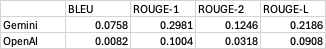

**Testing Metrics:**

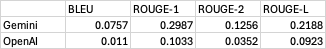

In [31]:
import matplotlib.pyplot as plt


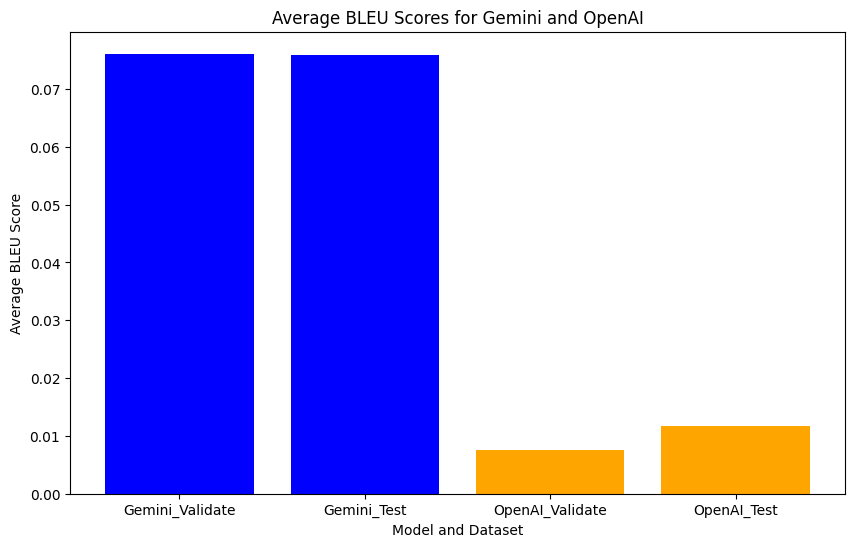

In [32]:
plt.figure(figsize=(10, 6))
plt.bar(['Gemini_Validate', 'Gemini_Test', 'OpenAI_Validate', 'OpenAI_Test'],
        [corpus_bleu_score_gemini_val, corpus_bleu_score_gemini, corpus_bleu_score_openAI_val, corpus_bleu_score_OpenAI],
        color=['blue', 'blue', 'orange', 'orange'])
plt.xlabel('Model and Dataset')
plt.ylabel('Average BLEU Score')
plt.title('Average BLEU Scores for Gemini and OpenAI')
plt.show()

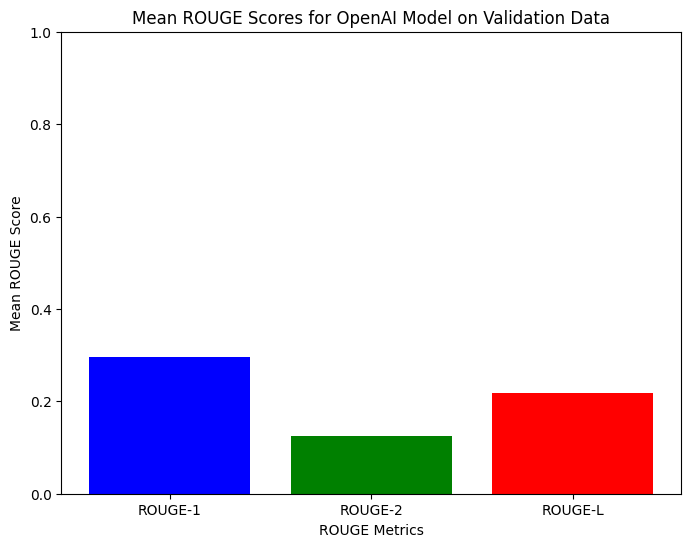

In [36]:
rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_mean_scores = [
    mean_rouge_1_gemini_val,
    mean_rouge_2_gemini_val,
    mean_rouge_L_gemini_val
]

plt.figure(figsize=(8, 6))
plt.bar(rouge_metrics, rouge_mean_scores, color=['blue', 'green', 'red'])

plt.xlabel('ROUGE Metrics')
plt.ylabel('Mean ROUGE Score')
plt.title('Mean ROUGE Scores for Gemini Model on Validation Data')
plt.ylim(0, 1)

plt.show()

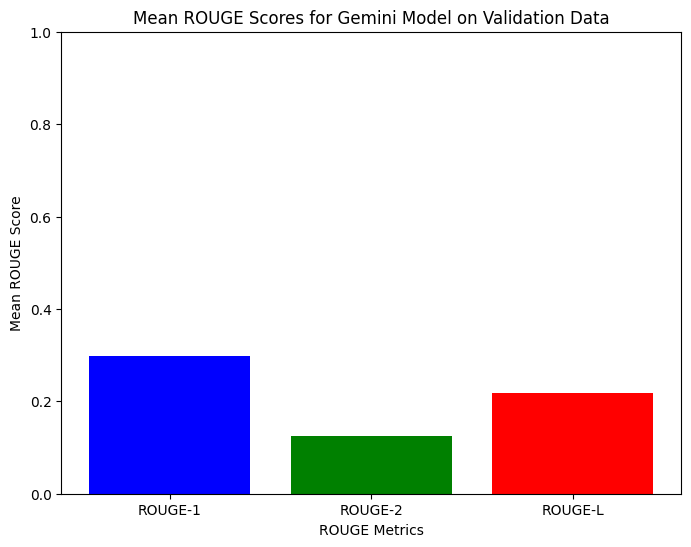

In [37]:
rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_mean_scores = [
    mean_rouge_1_gemini,
    mean_rouge_2_gemini,
    mean_rouge_L_gemini
]

plt.figure(figsize=(8, 6))
plt.bar(rouge_metrics, rouge_mean_scores, color=['blue', 'green', 'red'])

plt.xlabel('ROUGE Metrics')
plt.ylabel('Mean ROUGE Score')
plt.title('Mean ROUGE Scores for Gemini Model on Test Data')
plt.ylim(0, 1)

plt.show()

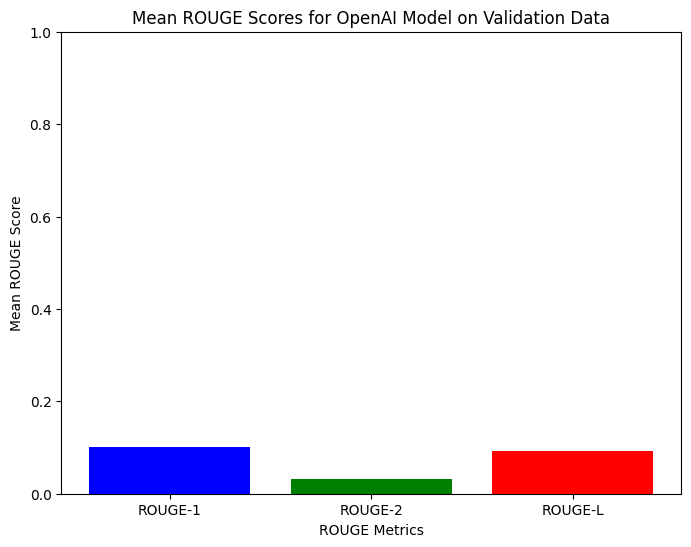

In [35]:
rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_mean_scores = [
    mean_rouge_1_openAI_val,
    mean_rouge_2_openAI_val,
    mean_rouge_L_openAI_val
]

plt.figure(figsize=(8, 6))
plt.bar(rouge_metrics, rouge_mean_scores, color=['blue', 'green', 'red'])

plt.xlabel('ROUGE Metrics')
plt.ylabel('Mean ROUGE Score')
plt.title('Mean ROUGE Scores for OpenAI Model on Validation Data')
plt.ylim(0, 1)

plt.show()

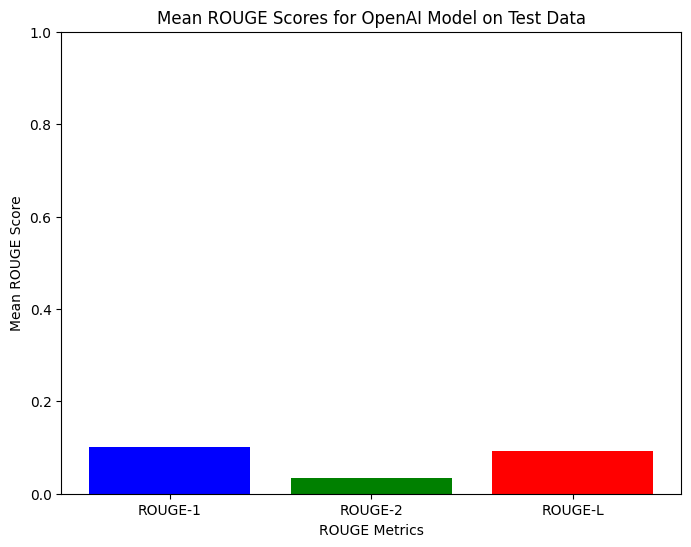

In [34]:
rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
rouge_mean_scores = [
    mean_rouge_1_openAI,
    mean_rouge_2_openAI,
    mean_rouge_L_openAI
]

plt.figure(figsize=(8, 6))
plt.bar(rouge_metrics, rouge_mean_scores, color=['blue', 'green', 'red'])

plt.xlabel('ROUGE Metrics')
plt.ylabel('Mean ROUGE Score')
plt.title('Mean ROUGE Scores for OpenAI Model on Test Data')
plt.ylim(0, 1)

plt.show()

**DISCUSSION:**

When comparing the results of the BLEU and ROUGE scores, we can see that Gemini performs better compared to OpenAI. This could be due to various reasons, such as the fact that we have used Gemini's own embedding model, as compared to OpenAI, where we have experimented with a Hugging Face embedding model.

Another reason is the chunk size used for character splitting for both Gemini and OpenAI.

STRENGTHS:

1. We have used an advanced image captioning model that gives better results compared to the model that has been used in the research paper.
2. Since it uses both Gemini and OpenAI models, it ensures that contextually relevent responses are given by leveraging the embeddings and the vector database.
3. Since the model has image captioning as well as hints and options, it enables the LLM to interpret and respond to questions that requires both visual and textual understanding.

WEAKNESSES:

1. Limited time and budget to be able to experiment with advanced versions of the LLMs.
2. Limited computing resources.
3. Further refinement of prompts could have enhanced accuracy with more time.


FUTURE WORK:

1. Being able to expand beyond image and text processing, by enabling audio, video processing.
2. Refine the prompts for LLMs to improve the contextual understanding and the reasoning of the chatbot.
3. Implement user feedback where a user can evaluate the response for accuracy and the chatbot adapts to it.